<a href="https://colab.research.google.com/github/avkornaev/Python-for-image-processing-course/blob/main/Cells_counter_v9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Summary
The cells counter algorithm is based on watershed method. If you want to know more, please check the following links: https://imagej.net/plugins/classic-watershed,
https://docs.opencv.org/master/d3/db4/tutorial_py_watershed.html

Install libraries. Execute code bellow just once to install the libraries. Then you may comment 'pip' lines using # in the begining of lines of the code.

In [86]:
!pip install czifile
!pip install tifffile
!pip install imagecodecs

Connect to Google disk.

In [87]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Import libraries.

In [88]:
import cv2
import numpy as np
#from scipy.ndimage.interpolation import zoom
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
from google.colab.patches import cv2_imshow
from scipy import ndimage
from skimage import measure, color, io, img_as_ubyte, img_as_float
from skimage.restoration import denoise_nl_means, estimate_sigma
from skimage.segmentation import clear_border
import pandas as pd
import czifile
import imagecodecs
#import tifffile

Check the settings.

In [89]:
#Image under study
img_path = '/content/drive/MyDrive/Cells_count/'
img_title = 'B16_1122_2_2.czi' # 'B16_control 2_2.czi'
pixels2microns = 0.396 #scale factor (check the image properties in Zen or Apeer)

#Visualisation
img_size = [0,0,1024,1024] # empty [] or rectangle coordinates, e.g. [0,0,512,512]
fig_size = (30,30) # figures size
img_map  = 'Blues' # image map. For example, 'gray','hot','jet','Blues' et al. If you want to know more, please type the following code: help(plt.imshow)
img_map1 = 'jet'

#Filtering
kernel = np.ones((5,5),np.uint8)
kernel4filt = 5
ps = 5 # patch_size
patchDist = 3 # patch_distance
hc = 115 # coefficient

numberOfIter = 2 #number of iterations
dist_transf_ratio = 0.1 # distance transform ratio
dist_transf_param = 5
markers_bias = 100

clearBorder = 'off' # delete markers at the borders: 'on' or 'off'

Download "czi" image and create slices of the image.

In [90]:
img = czifile.imread(img_path + img_title)

if img_size == []:
  img_size = [0,0,img.shape[5],img.shape[6]] # full size

img_slice = img[0,0,0,:,0,img_size[0]:img_size[2],img_size[1]:img_size[3],0]# image in a form of 3D matrix
img0 = img_slice[0,:,:] # 0 channel that is fluo4-T1 (highlights the apoptosed cells)
img1 = img_slice[1,:,:] # 1 channel that is H3342-T2 (highlights all the cells)
channels = [img0,img1] # channels of the image

nc = len(channels)
n = [i for i in range(nc)] # auxiliary variable 

print('CZI image shape: ',img.shape)# ?, ?, ?,number of chanels,x size,y size, ?
for i in n:
  print(i,'channel shape: ',channels[i].shape, channels[i].dtype, type(channels[i]))
  print(np.amax(channels[i]))
print('0 channel shape: ',img0.shape,img0.dtype,type(img0))
print(np.amax(img0))
print('1 channel shape: ',img1.shape,img1.dtype,type(img1))
print(np.amax(img1))

CZI image shape:  (1, 1, 1, 2, 1, 3277, 3277, 1)
0 channel shape:  (1024, 1024) uint16 <class 'numpy.ndarray'>
64754
1 channel shape:  (1024, 1024) uint16 <class 'numpy.ndarray'>
65535
0 channel shape:  (1024, 1024) uint16 <class 'numpy.ndarray'>
64754
1 channel shape:  (1024, 1024) uint16 <class 'numpy.ndarray'>
65535


Create templates (empty lists).

In [91]:
channelsF = [0]*nc # filtered channels template
img_path_temp = [0]*nc # another one template
channelsFGray = [0]*nc # and another one
ret = [0]*nc # one more template
thresh = [0]*nc # one more template
opening = [0]*nc # one more template
sure_bg = [0]*nc # one more template
sure_fg = [0]*nc # one more template
ret1 = [0]*nc # one more template
dist_transform = [0]*nc # one more template
unknown = [0]*nc # one more template
ret2 = [0]*nc # one more template
markers = [0]*nc # one more template
channelsFB = [0]*nc # one more template
channelsFW = [0]*nc # one more template
regions = [0]*nc
numberOfCells = [0]*nc

Filter channel images of the base image.

In [92]:
#sigma_est = [0]*nc
#patch_kw = [0]*nc

for i in n:
  # "denoise_nl_means" performs non-local means denoising
  sigma_est = np.mean(estimate_sigma(channels[i], multichannel=False))
  patch_kw = dict(patch_size=ps, patch_distance=patchDist, multichannel=False)
  channelsF[i] = denoise_nl_means(channels[i], h=hc*sigma_est, fast_mode=False, **patch_kw)
  
  channelsF[i] = np.uint16(channelsF[i])
  # Apply bilateral filter
  #d = 15 #diameter of each pixel neighborhood that is used during filtering
  #sigmaColor = 2000
  #sigmaSpace = 100
  #channelsF[i] = cv2.bilateralFilter(channelsF[i], d, sigmaColor, sigmaSpace)

  # Apply a multidimensional median filter
  channelsF[i] = ndimage.median_filter(channelsF[i], size=kernel4filt)

  print(i,'channel sigma estimation = ',sigma_est)
  print(i,'channel shape: ',channelsF[i].shape, channelsF[i].dtype, type(channelsF[i]))
  print(np.amax(channelsF[i]))
   

0 channel sigma estimation =  3.1868817164581675
0 channel shape:  (1024, 1024) uint16 <class 'numpy.ndarray'>
50940
1 channel sigma estimation =  236.18051028651746
1 channel shape:  (1024, 1024) uint16 <class 'numpy.ndarray'>
65535


Visualize channels before and after filtering.

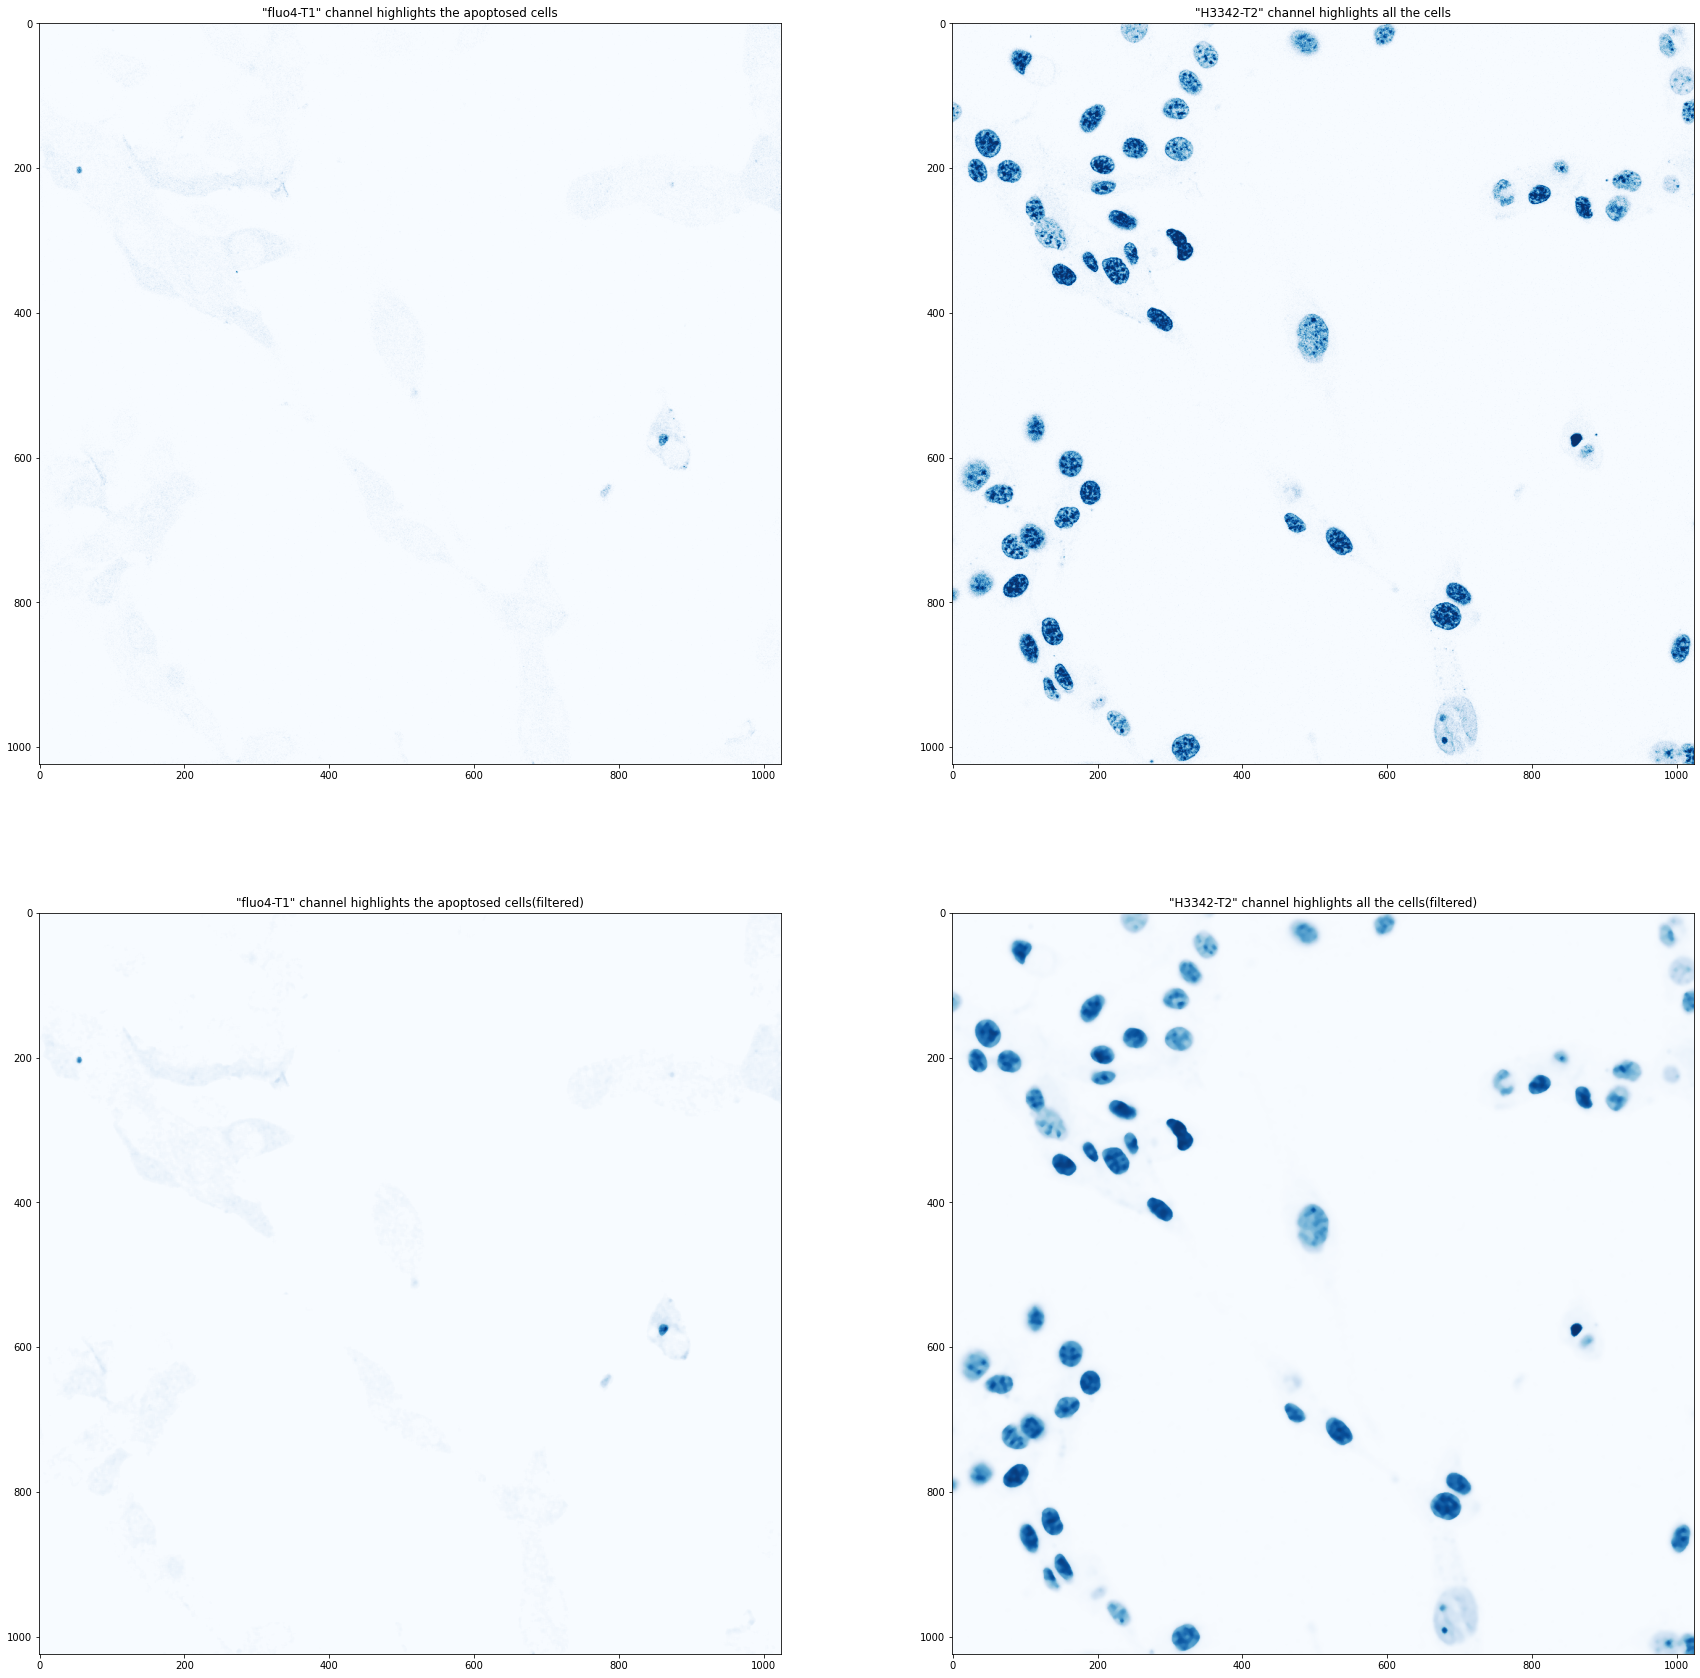

In [93]:
titles = ['"fluo4-T1" channel highlights the apoptosed cells',
          '"H3342-T2" channel highlights all the cells']
plt.figure(figsize=(fig_size[0],fig_size[1]))
for i in n:
  plt.subplot(2,2,i+1)
  plt.imshow(channels[i],cmap=img_map)
  plt.title(titles[i])
  plt.subplot(2,2,i+3)
  plt.imshow(channelsF[i],cmap=img_map)
  plt.title(titles[i]+'(filtered)')  

In [94]:
#plt.figure(figsize=fig_size)
#plt.imshow(channelsF[1],cmap = img_map)

Create tepmorary files.

In [95]:
for i in n:
  img_path_temp[i] = img_path + img_title[0:-4] + '_ch' + str(i) + '.tiff' # path 0
  cv2.imwrite(img_path_temp[i], channelsF[i]) # save channels in a temporary tiff file
print(img_path_temp)

['/content/drive/MyDrive/Cells_count/B16_1122_2_2_ch0.tiff', '/content/drive/MyDrive/Cells_count/B16_1122_2_2_ch1.tiff']


Read image using OpenCV.

In [96]:
for i in n:
  channelsFGray[i] = cv2.imread(img_path_temp[i],cv2.IMREAD_GRAYSCALE)
  print(type(channelsFGray[i]),channelsFGray[i].shape,channelsFGray[i].dtype)

<class 'numpy.ndarray'> (1024, 1024) uint8
<class 'numpy.ndarray'> (1024, 1024) uint8


Threshold image to binary using OTSU. All the thresholded pixels are set to 255. Then remove noise (opening) and remove edge touching with clear_border function.

In [97]:
for i in n:
  ret[i], thresh[i] = cv2.threshold(channelsFGray[i], 0, 255, 
                                    cv2.THRESH_BINARY+cv2.THRESH_OTSU)
  opening[i] = cv2.morphologyEx(thresh[i],cv2.MORPH_OPEN,kernel,
                                iterations = numberOfIter)
  if clearBorder == 'on':
    opening[i] = clear_border(opening[i])

Identify background and foreground area (OpenCV - Distance Transformation). Apply watershed.

In [98]:
for i in n:
  sure_bg[i] = cv2.dilate(opening[i],
                          kernel,iterations=numberOfIter) # sure background
  dist_transform[i] = cv2.distanceTransform(opening[i],cv2.DIST_L2,
                                            dist_transf_param)
  
  ret1[i], sure_fg[i] = cv2.threshold(dist_transform[i],
                                      dist_transf_ratio*dist_transform[i].max(),
                                      255,0)
  sure_fg[i] = np.uint8(sure_fg[i]) # sure foreground
  
  unknown[i] = cv2.subtract(sure_bg[i], sure_fg[i])
  ret2[i], markers[i] = cv2.connectedComponents(sure_fg[i])
  markers[i] = markers[i] + markers_bias
  markers[i][unknown[i]==255] = 0

  markers[i] = cv2.watershed(cv2.imread(img_path_temp[i]),markers[i]) #The boundary regions will be marked as -1

  channelsFB[i] = cv2.imread(img_path_temp[i])
  channelsFB[i][markers[i] == -1] = [255,0,0]
  channelsFW[i] = color.label2rgb(markers[i], bg_label = 0)

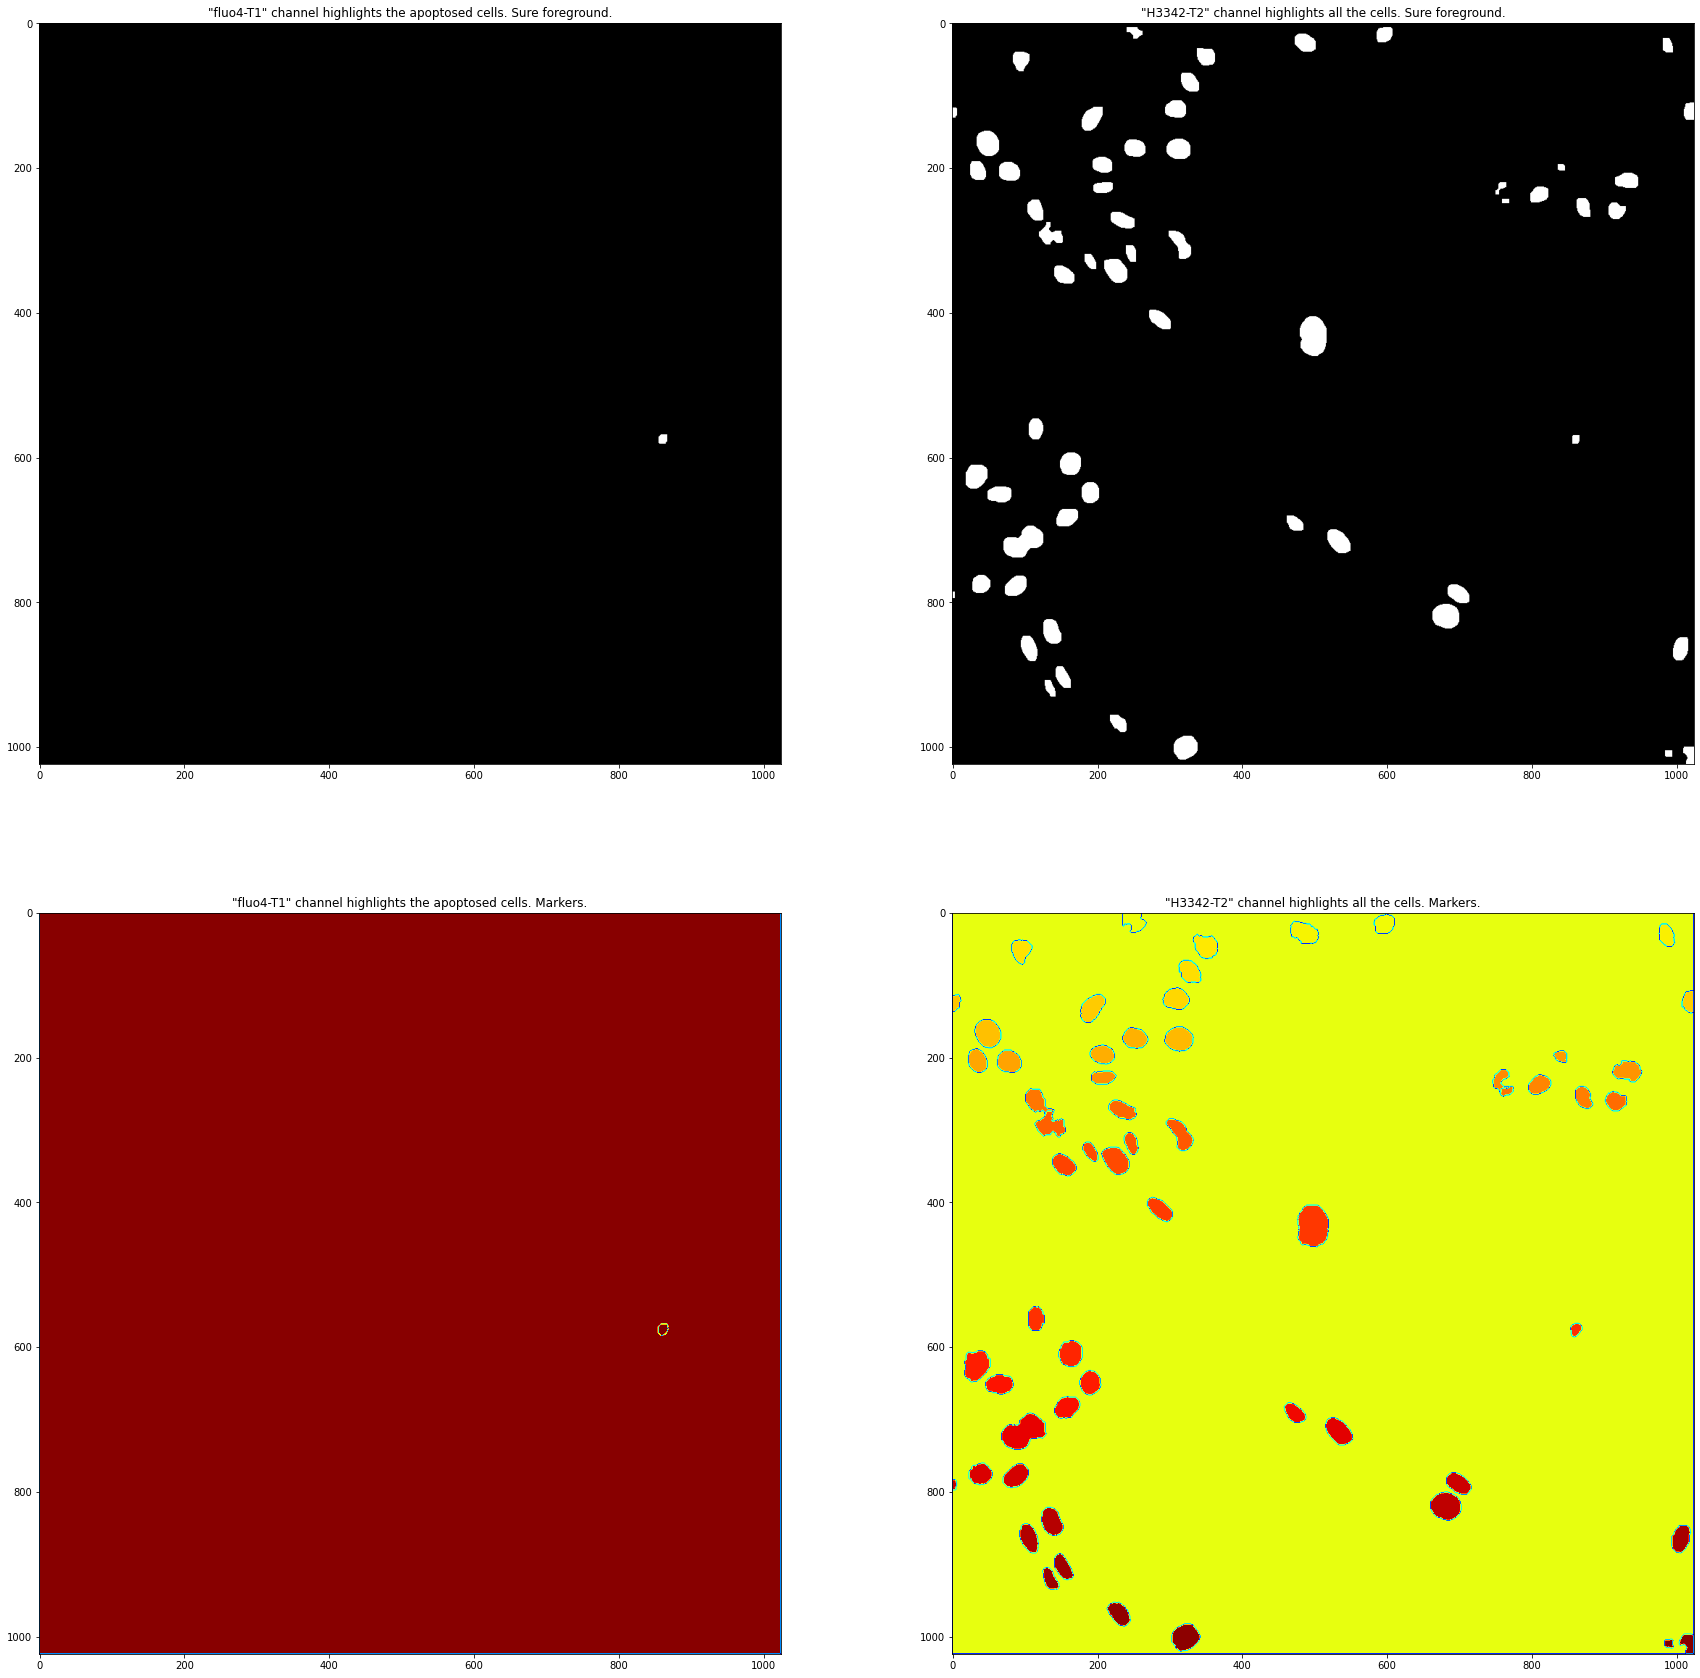

In [99]:
plt.figure(figsize=(fig_size[0],fig_size[1]))
for i in n:
  plt.subplot(2,2,i+1)
  plt.imshow(sure_fg[i],cmap='binary_r')
  plt.title(titles[i]+'. Sure foreground.')
  plt.subplot(2,2,i+3)
  plt.imshow(markers[i],cmap=img_map1)
  plt.title(titles[i]+ '. Markers.')

Calculate metrics.
https://scikit-image.org/docs/dev/api/skimage.measure.html#skimage.measure.regionprops

In [100]:
for i in n:
  regions[i] = measure.regionprops(markers[i], intensity_image=channels[i])
  numberOfCells[i] = len(regions[i])-1
  #print(regions[i])
print('Numbers of cells in channel images are equal to',numberOfCells)

Numbers of cells in channel images are equal to [1, 59]


Visualise and save metrics data.

In [101]:
d = [0]*nc
df_temp = [0]*nc

for i in n:
  nr = [i for i in range(len(regions[i]))]
  d[i] = pd.DataFrame()
  for j in nr:
    df_temp[i] = pd.DataFrame({'No':j, 
                          'Area (mum^2)':int(regions[i][j].area*(pixels2microns**2)),
                          'Equiv.diam. (mum)': regions[i][j].equivalent_diameter*pixels2microns,
                          'Major axis length (mum)':regions[i][j].major_axis_length*pixels2microns,
                          'Minor axis length (mum)':regions[i][j].minor_axis_length*pixels2microns,
                          'Mean intensity':regions[i][j].mean_intensity,
                          'Euler number': regions[i][j].euler_number,
                          'Centroid':[regions[i][j].centroid],
                          'Bounding box':[regions[i][j].bbox]})
    d[i] = pd.concat([d[i],df_temp[i]])
    d[i].to_csv(img_path + img_title[0:-4] +'_channel_'+str(i) + '.csv')  

In [102]:
#Channel 0 ("fluo4-T1").
d[0]

,No,Area (mum^2),Equiv.diam. (mum),Major axis length (mum),Minor axis length (mum),Mean intensity,Euler number,Centroid,Bounding box
0,0,163760,456.624865,467.365679,467.300896,268.798562,0,"(511.48777152575354, 511.4331293019906)","(1, 1, 1023, 1023)"
0,1,24,5.581007,6.328826,4.969913,37504.121795,1,"(575.3910256410256, 860.6153846153846)","(569, 855, 584, 868)"


In [103]:
#Channel 1 ("H3342-T2").
d[1]

,No,Area (mum^2),Equiv.diam. (mum),Major axis length (mum),Minor axis length (mum),Mean intensity,Euler number,Centroid,Bounding box
0,0,156711,446.689105,466.630509,464.041880,685.914691,-51,"(514.3244964391249, 519.3395144561423)","(1, 1, 1023, 1023)"
0,1,92,10.826032,13.477759,9.592184,24159.156729,1,"(12.20954003407155, 250.82112436115844)","(1, 236, 28, 268)"
0,2,87,10.583558,11.452214,9.869300,35533.297683,1,"(16.124777183600713, 596.3386809269163)","(3, 583, 29, 610)"
0,3,128,12.811092,16.365770,10.150771,33111.739659,1,"(28.100973236009732, 485.8272506082725)","(13, 468, 43, 505)"
0,4,74,9.707809,12.742204,7.456086,28028.641949,1,"(31.771186440677965, 985.7584745762712)","(17, 976, 47, 997)"
0,5,122,12.487508,14.141747,11.411264,30794.559539,1,"(46.892445582586426, 349.93854033290654)","(31, 333, 64, 366)"
0,6,96,11.072213,12.620052,10.244141,49899.578176,1,"(52.527687296416936, 94.96579804560261)","(39, 83, 72, 110)"
0,7,105,11.600593,14.002456,9.716540,38660.872404,1,"(81.96439169139465, 327.7581602373887)","(67, 313, 97, 343)"
0,8,122,12.495500,13.935713,11.286314,37420.372123,1,"(119.55882352941177, 308.9194373401535)","(105, 291, 134, 327)"
0,9,56,8.466374,12.118813,6.199676,38575.874652,1,"(123.16434540389972, 1016.0919220055711)","(109, 1008, 139, 1023)"


Visualize boundaries and cells.

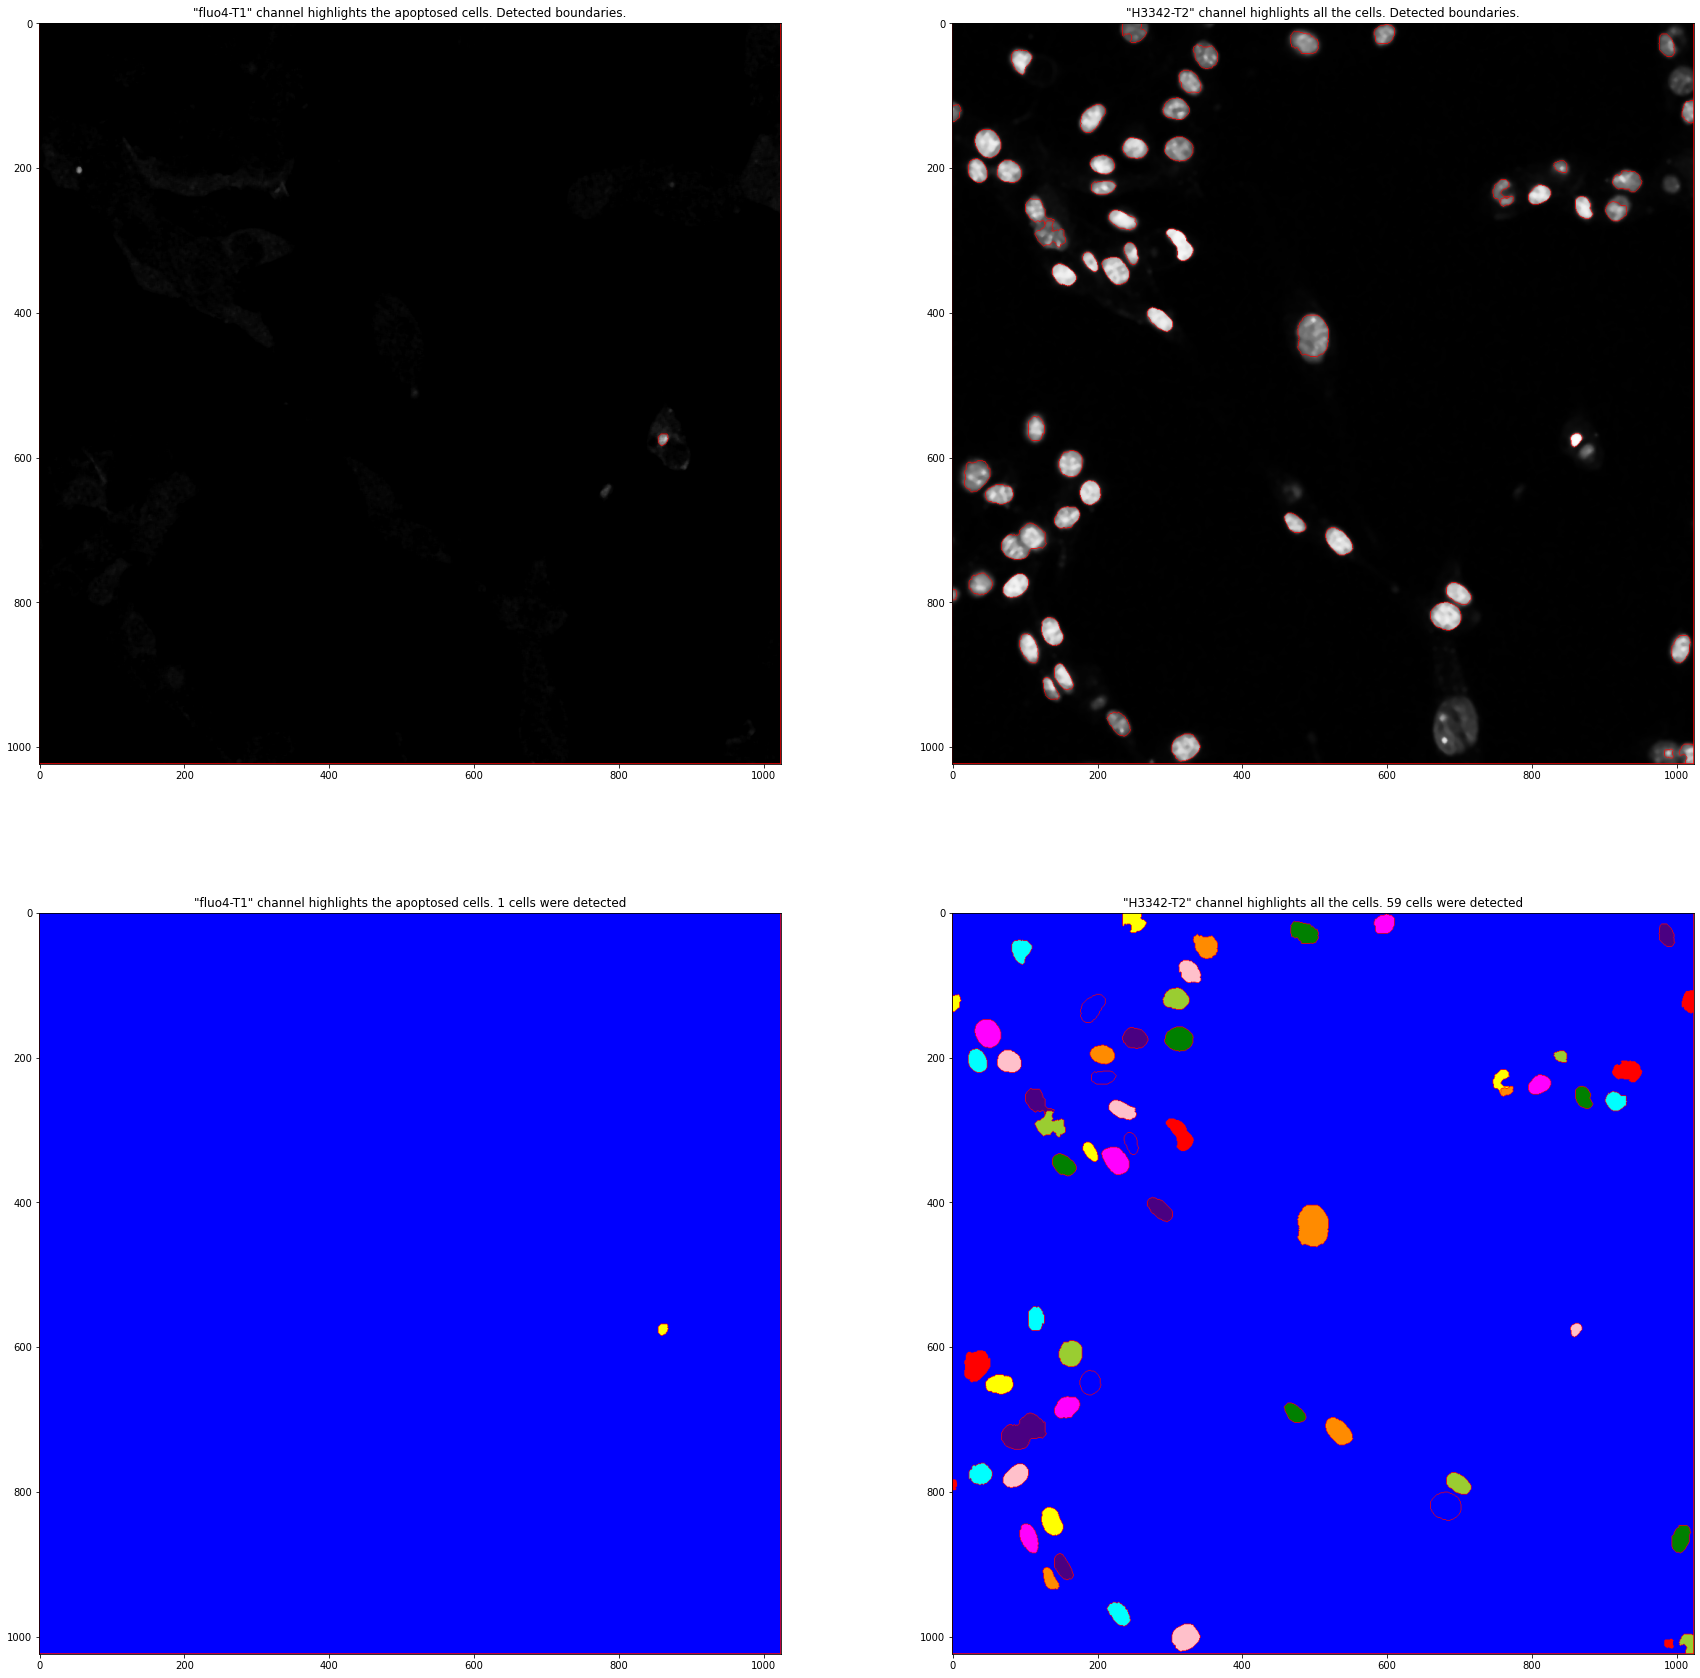

In [104]:
fig, ax = plt.subplots(figsize=(fig_size[0],fig_size[1]))
for i in n:
  plt.subplot(2,2,i+1)
  plt.imshow(channelsFB[i],cmap=img_map)
  plt.title(titles[i]+'. Detected boundaries.')
  plt.subplot(2,2,i+3)
  plt.imshow(channelsFW[i],cmap=img_map1)
  plt.title(titles[i]+ '. ' + str(numberOfCells[i]) + ' cells were detected')